In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 80% 119M/149M [00:01<00:00, 127MB/s]
100% 149M/149M [00:01<00:00, 133MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")
#-------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/content/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_1384.jpg,notumor
1,/content/Training/notumor/Tr-no_1019.jpg,notumor
2,/content/Training/notumor/Tr-no_0128.jpg,notumor
3,/content/Training/notumor/Tr-no_1327.jpg,notumor
4,/content/Training/notumor/Tr-no_0346.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_1132.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0384.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0708.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0574.jpg,glioma


In [ ]:
ts_df = test_df('/content/Testing')

In [ ]:
ts_df


,Class Path,Class
0,/content/Testing/notumor/Te-no_0179.jpg,notumor
1,/content/Testing/notumor/Te-no_0244.jpg,notumor
2,/content/Testing/notumor/Te-no_0151.jpg,notumor
3,/content/Testing/notumor/Te-no_0180.jpg,notumor
4,/content/Testing/notumor/Te-no_0199.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0221.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0157.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0015.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0281.jpg,glioma


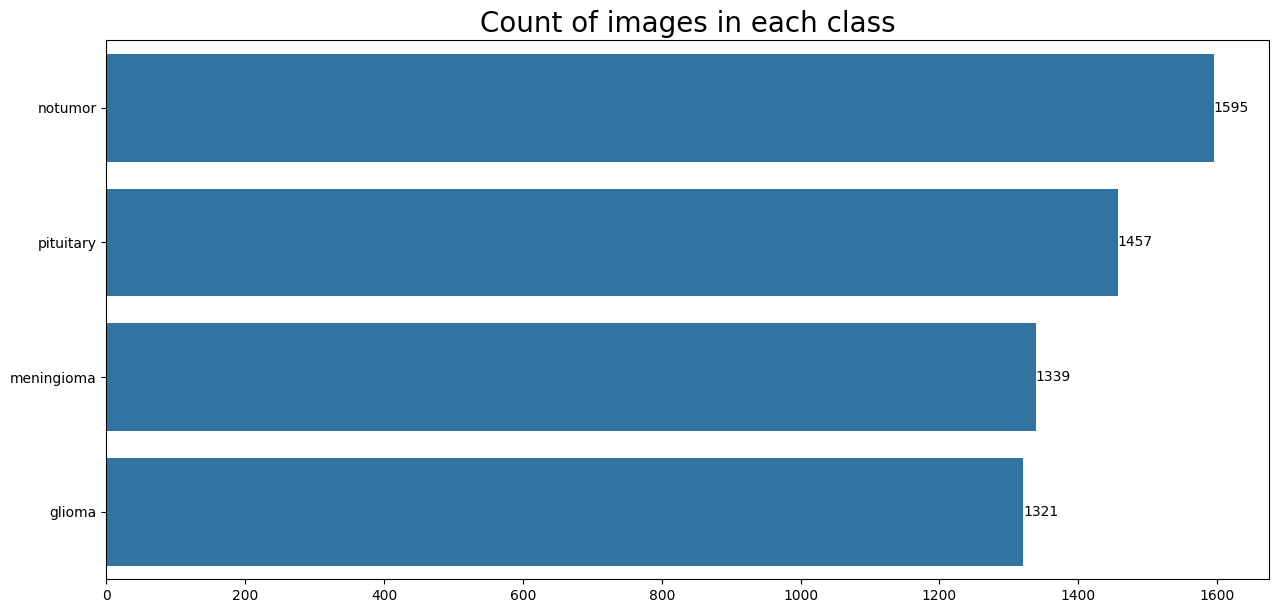

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

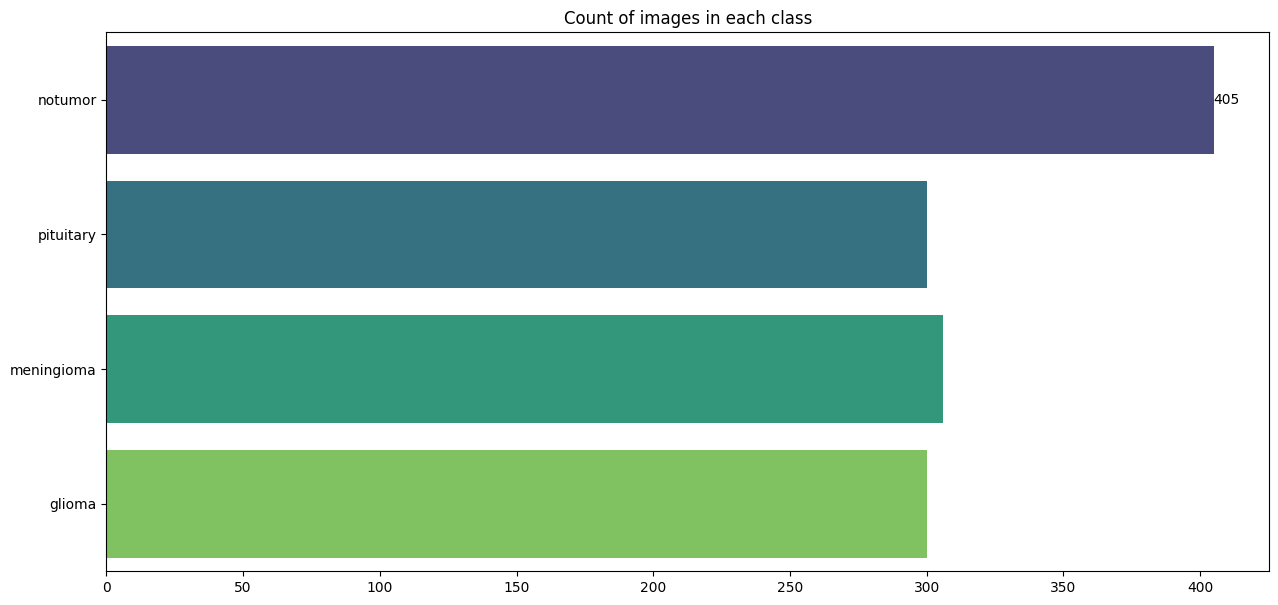

In [ ]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])


In [ ]:
valid_df


,Class Path,Class
1297,/content/Testing/glioma/Te-gl_0167.jpg,glioma
723,/content/Testing/meningioma/Te-me_0188.jpg,meningioma
466,/content/Testing/pituitary/Te-pi_0061.jpg,pituitary
778,/content/Testing/meningioma/Te-me_0146.jpg,meningioma
1120,/content/Testing/glioma/Te-gl_0285.jpg,glioma
...,...,...
1070,/content/Testing/glioma/Te-gl_0122.jpg,glioma
254,/content/Testing/notumor/Te-no_0061.jpg,notumor
1284,/content/Testing/glioma/Te-gl_0217.jpg,glioma
899,/content/Testing/meningioma/Te-me_0287.jpg,meningioma


In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


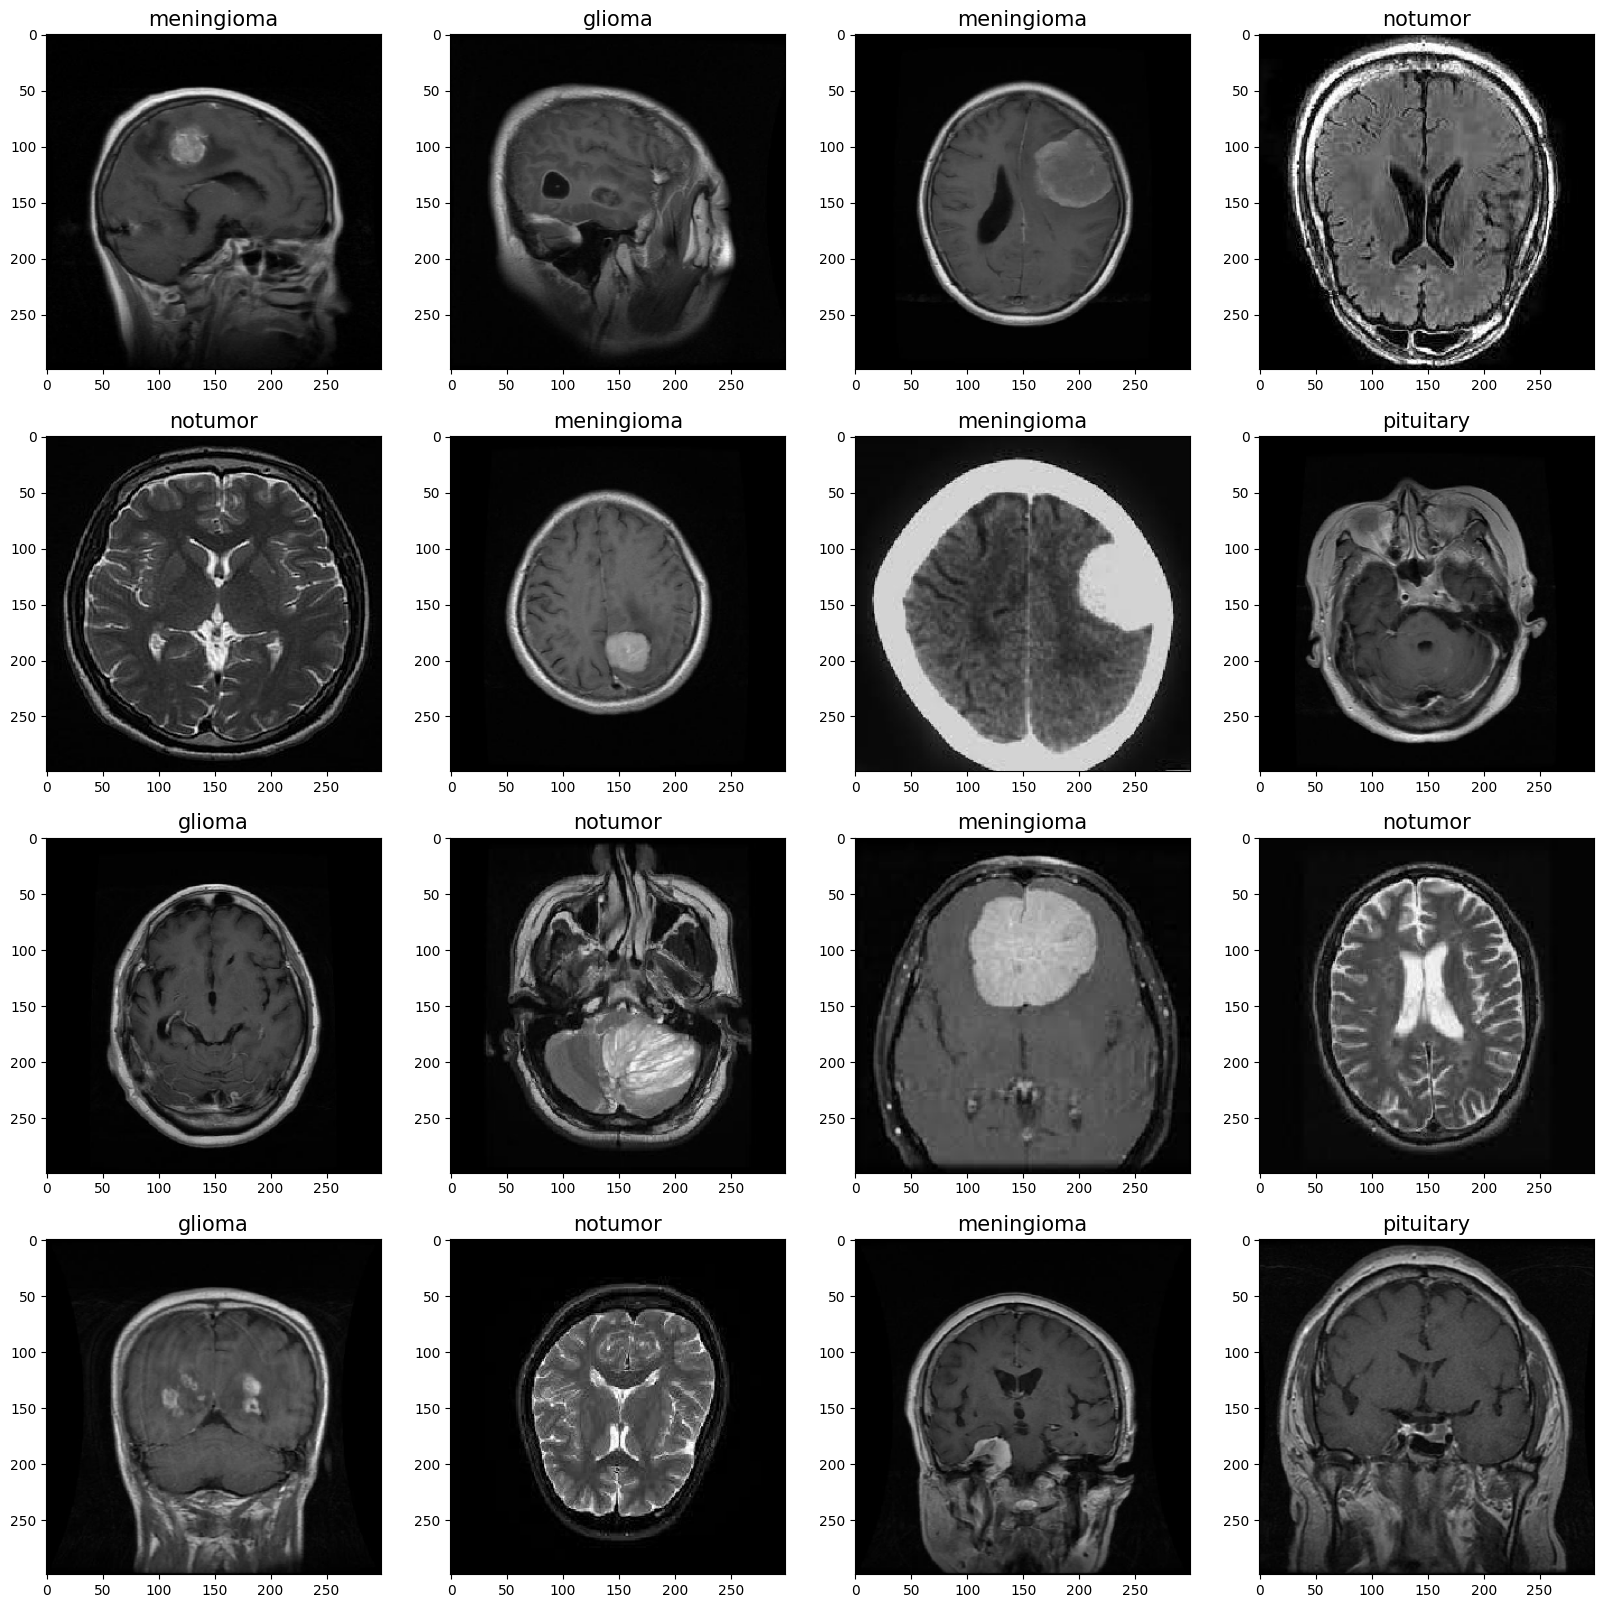

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

#Xception

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21

In [ ]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
 20/179 [==>...........................] - ETA: 2:36 - loss: 1.1279 - accuracy: 0.5641 - precision_1: 0.7692 - recall_1: 0.3438

KeyboardInterrupt: 

##Evaluation

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(hist.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(hist.history['val_loss'], label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot both training accuracy and validation accuracy on the same plot
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_score = model.evaluate(ts_gen, verbose = 1)

In [ ]:
y_test = ts_gen.classes
y_pred = model.predict(ts_gen, verbose = 1)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
train_dir='/content/Training'
labels = os.listdir(train_dir)
print(classification_report(y_test,y_pred,target_names = labels))

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

In [ ]:
model.save('xception.h5')

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf

# Load your pre-trained model for brain tumor classification
model_path = '/content/cnn_97_95.h5'
brain_model = load_model(model_path)

# Define the class names for the 4 classes
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_tumor(image):
    # Resize the image to the input shape required by the model
    image = Image.fromarray(image).resize((299, 299))
    # Convert the image to a numpy array and normalize it
    image_array = np.array(image) / 255.0
    # Ensure the image has 3 channels (RGB), if not convert it
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,)*3, axis=-1)
    # Reshape the image to match the model's input shape
    image_array = image_array.reshape(-1, 299, 299, 3)
    # Predict the class using the model
    predictions = brain_model.predict(image_array)
    # Get the index of the highest prediction
    predicted_class_index = np.argmax(predictions)
    # Get the class name
    predicted_class = class_names[predicted_class_index]
    return f"Predicted Tumor Class: {predicted_class}"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    title="Brain Tumor MRI Classification",
    description="Upload an MRI image to predict the brain tumor class."
)

# Launch the interface
iface.launch()

#cnn

In [ ]:
# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
SEED = 111
image_shape = (299,299, 3)
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(4, activation="softmax"))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 296, 296, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 98, 98, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 95, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 9, 9, 128)        

In [ ]:
from keras.optimizers import Adam
model_1.compile(Adam(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

In [ ]:
hist = model_1.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 49s 220ms/step - loss: 0.7709 - accuracy: 0.6651 - precision: 0.7688 - recall: 0.5467 - val_loss: 0.5357 - val_accuracy: 0.7664 - val_precision: 0.7933 - val_recall: 0.7267
Epoch 2/10
179/179 [==============================] - 37s 205ms/step - loss: 0.4392 - accuracy: 0.8300 - precision: 0.8510 - recall: 0.8032 - val_loss: 0.4079 - val_accuracy: 0.8229 - val_precision: 0.8294 - val_recall: 0.8092
Epoch 3/10
179/179 [==============================] - 37s 208ms/step - loss: 0.3060 - accuracy: 0.8904 - precision: 0.9008 - recall: 0.8775 - val_loss: 0.3915 - val_accuracy: 0.8412 - val_precision: 0.8513 - val_recall: 0.8305
Epoch 4/10
179/179 [==============================] - 36s 203ms/step - loss: 0.2193 - accuracy: 0.9237 - precision: 0.9289 - recall: 0.9154 - val_loss: 0.2299 - val_accuracy: 0.8962 - val_precision: 0.9020 - val_recall: 0.8855
Epoch 5/10
179/179 [==============================] - 38s 214ms/step - loss: 0.1738 - accura

##evaluation

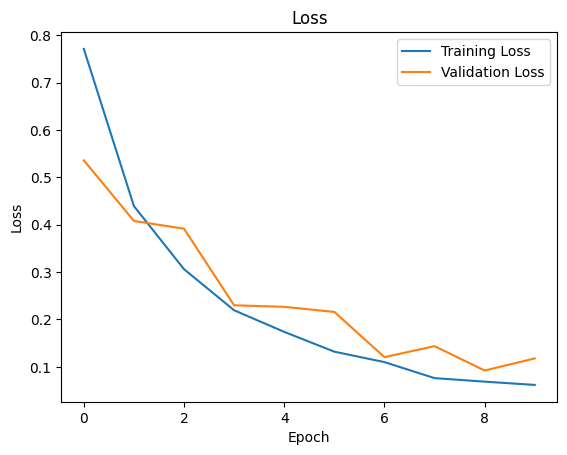

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(hist.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(hist.history['val_loss'], label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

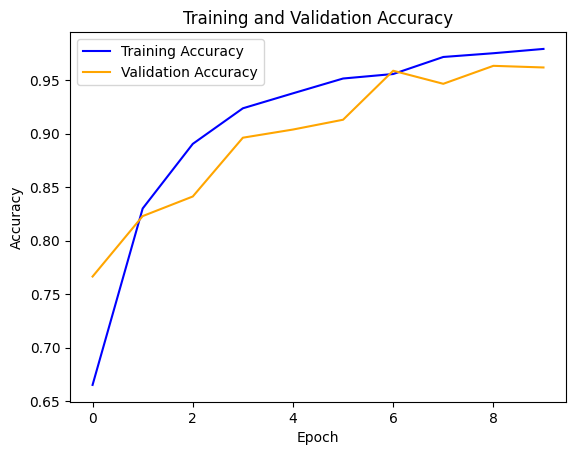

In [ ]:
import matplotlib.pyplot as plt

# Plot both training accuracy and validation accuracy on the same plot
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_score = model_1.evaluate(ts_gen, verbose = 1)

41/41 [==============================] - 3s 79ms/step - loss: 0.1462 - accuracy: 0.9588 - precision: 0.9602 - recall: 0.9573


In [ ]:
y_test = ts_gen.classes
y_pred = model_1.predict(ts_gen, verbose = 1)
y_pred = np.argmax(y_pred,axis=1)

41/41 [==============================] - 2s 49ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
train_dir='/content/Training'
labels = os.listdir(train_dir)
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

   pituitary       0.96      0.93      0.94       150
  meningioma       0.92      0.93      0.93       153
     notumor       0.99      0.99      0.99       203
      glioma       0.97      0.97      0.97       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



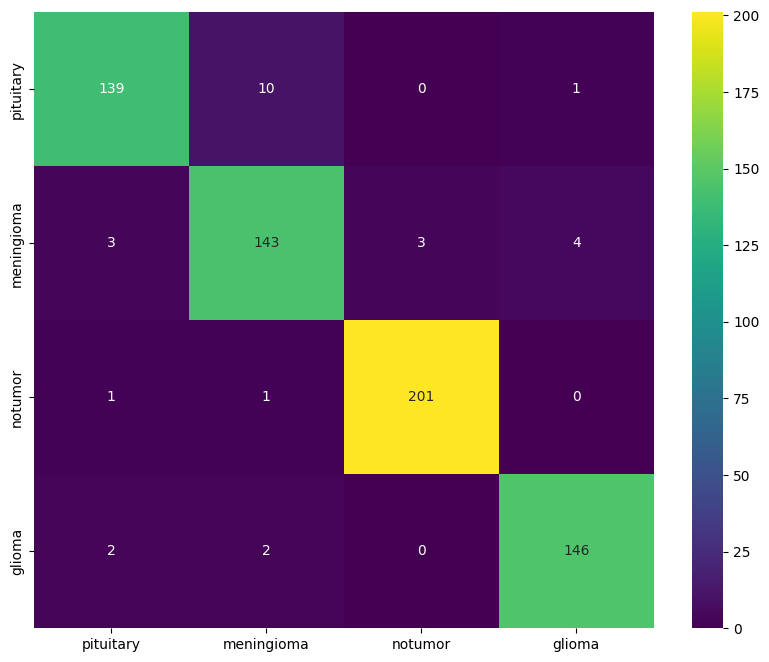

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

In [ ]:
model_1.save('cnn_97_95.h5')

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf

# Load your pre-trained model for brain tumor classification
model_path = '/content/dense_net_121_94_91.h5'
brain_model = load_model(model_path)

# Define the class names for the 4 classes
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_tumor(image):
    # Resize the image to the input shape required by the model
    image = Image.fromarray(image).resize((299, 299))
    # Convert the image to a numpy array and normalize it
    image_array = np.array(image) / 255.0
    # Ensure the image has 3 channels (RGB), if not convert it
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,)*3, axis=-1)
    # Reshape the image to match the model's input shape
    image_array = image_array.reshape(-1, 299, 299, 3)
    # Predict the class using the model
    predictions = brain_model.predict(image_array)
    # Get the index of the highest prediction
    predicted_class_index = np.argmax(predictions)
    # Get the class name
    predicted_class = class_names[predicted_class_index]
    return f"Predicted Tumor Class: {predicted_class}"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    title="Brain Tumor MRI Classification",
    description="Upload an MRI image to predict the brain tumor class."
)

# Launch the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d6287f44e84758e39e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#Resnet50


In [ ]:
from keras import layers
# Create the ResNet50 model and set the layers to be non-trainable
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(299, 299, 3),
                                                  pooling='max',
                                                  weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(4, activation='softmax'))

In [ ]:
# Compile and train the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(tr_gen, validation_data=valid_gen, epochs=10)

Epoch 1/10
179/179 [==============================] - 59s 280ms/step - loss: 1.9003 - accuracy: 0.5376 - val_loss: 1.4797 - val_accuracy: 0.4351
Epoch 2/10
179/179 [==============================] - 45s 251ms/step - loss: 0.9375 - accuracy: 0.6217 - val_loss: 1.3315 - val_accuracy: 0.4962
Epoch 3/10
179/179 [==============================] - 52s 290ms/step - loss: 0.8809 - accuracy: 0.6385 - val_loss: 0.7909 - val_accuracy: 0.6443
Epoch 4/10
179/179 [==============================] - 67s 373ms/step - loss: 0.7513 - accuracy: 0.7001 - val_loss: 0.8867 - val_accuracy: 0.6962
Epoch 5/10
179/179 [==============================] - 62s 345ms/step - loss: 0.6817 - accuracy: 0.7167 - val_loss: 0.8433 - val_accuracy: 0.6580
Epoch 6/10
179/179 [==============================] - 49s 275ms/step - loss: 0.6613 - accuracy: 0.7215 - val_loss: 0.7107 - val_accuracy: 0.7145
Epoch 7/10
179/179 [==============================] - 46s 255ms/step - loss: 0.6649 - accuracy: 0.7148 - val_loss: 0.6853 - val_ac

##Evaluation

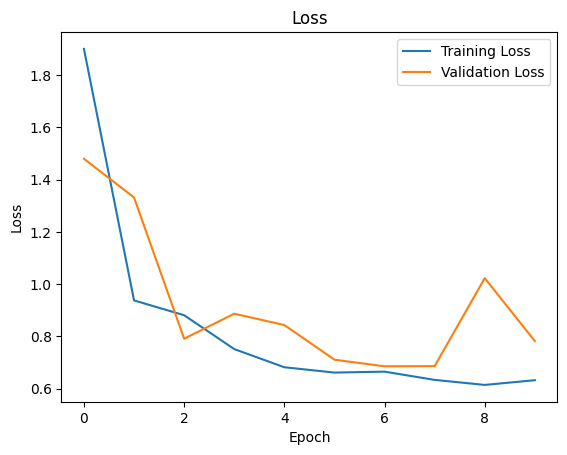

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

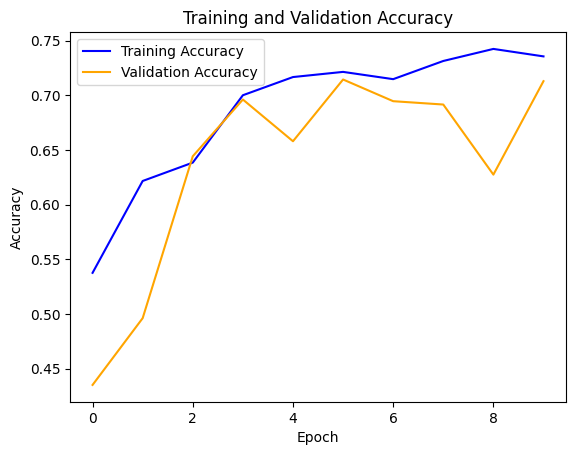

In [ ]:
import matplotlib.pyplot as plt

# Plot both training accuracy and validation accuracy on the same plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_score = resnet_model.evaluate(ts_gen, verbose = 1)

41/41 [==============================] - 4s 100ms/step - loss: 0.7447 - accuracy: 0.7088


In [ ]:
y_test = ts_gen.classes
y_pred = resnet_model.predict(ts_gen, verbose = 1)
y_pred = np.argmax(y_pred,axis=1)

41/41 [==============================] - 5s 104ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
train_dir='/content/Training'
labels = os.listdir(train_dir)
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

   pituitary       0.60      0.85      0.70       150
  meningioma       0.78      0.05      0.09       153
     notumor       0.87      0.92      0.89       203
      glioma       0.65      0.96      0.78       150

    accuracy                           0.71       656
   macro avg       0.73      0.69      0.62       656
weighted avg       0.74      0.71      0.64       656



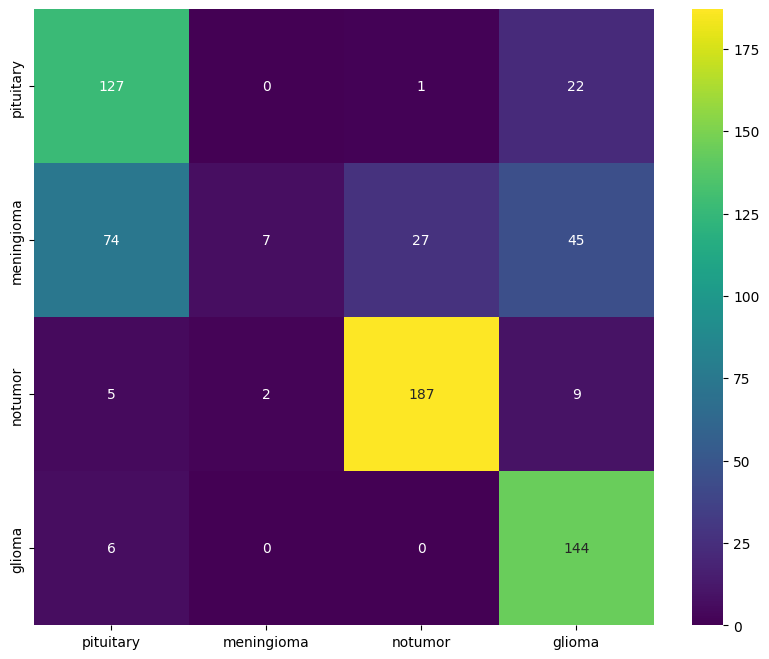

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

In [ ]:
resnet_model.save('res_net_50_73.h5')

#densenet121

In [ ]:
DenseNet121 = Sequential()
pretrained_model = tf.keras.applications.DenseNet121(include_top=False,
                                                  input_shape=(299,299,3),
                                                  pooling='max',
                                                  weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False
DenseNet121.add(pretrained_model)
DenseNet121.add(layers.Flatten())
DenseNet121.add(layers.Dense(512, activation='relu'))
DenseNet121.add(layers.Dense(4, activation='softmax'))

DenseNet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
history = DenseNet121.fit(tr_gen, validation_data=valid_gen, epochs=10)

Epoch 1/10
179/179 [==============================] - 70s 314ms/step - loss: 0.8998 - accuracy: 0.7887 - val_loss: 0.4400 - val_accuracy: 0.8412
Epoch 2/10
179/179 [==============================] - 45s 250ms/step - loss: 0.3342 - accuracy: 0.8778 - val_loss: 0.3542 - val_accuracy: 0.8779
Epoch 3/10
179/179 [==============================] - 45s 250ms/step - loss: 0.2962 - accuracy: 0.8883 - val_loss: 0.3270 - val_accuracy: 0.8809
Epoch 4/10
179/179 [==============================] - 62s 346ms/step - loss: 0.2671 - accuracy: 0.9002 - val_loss: 0.3691 - val_accuracy: 0.8748
Epoch 5/10
179/179 [==============================] - 64s 356ms/step - loss: 0.1985 - accuracy: 0.9268 - val_loss: 0.2747 - val_accuracy: 0.9099
Epoch 6/10
179/179 [==============================] - 56s 310ms/step - loss: 0.1733 - accuracy: 0.9356 - val_loss: 0.2063 - val_accuracy: 0.9130
Epoch 7/10
179/179 [==============================] - 45s 248ms/step - loss: 0.1695 - accuracy: 0.9389 - val_loss: 0.2481 - val_ac

##evaluation

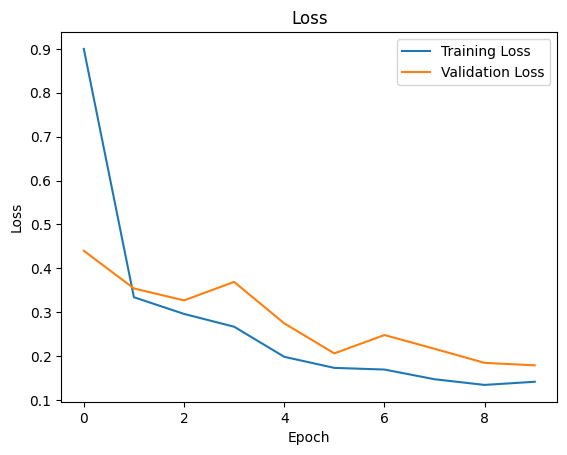

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

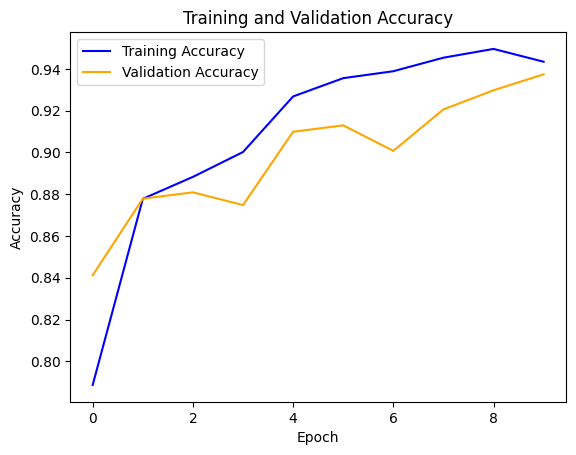

In [ ]:
import matplotlib.pyplot as plt

# Plot both training accuracy and validation accuracy on the same plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_score = DenseNet121.evaluate(ts_gen, verbose = 1)

41/41 [==============================] - 4s 87ms/step - loss: 0.2010 - accuracy: 0.9131


In [ ]:
y_test = ts_gen.classes
y_pred = resnet_model.predict(ts_gen, verbose = 1)
y_pred = np.argmax(y_pred,axis=1)

41/41 [==============================] - 4s 97ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
train_dir='/content/Training'
labels = os.listdir(train_dir)
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

   pituitary       0.60      0.85      0.70       150
  meningioma       0.78      0.05      0.09       153
     notumor       0.87      0.92      0.89       203
      glioma       0.65      0.96      0.78       150

    accuracy                           0.71       656
   macro avg       0.73      0.69      0.62       656
weighted avg       0.74      0.71      0.64       656



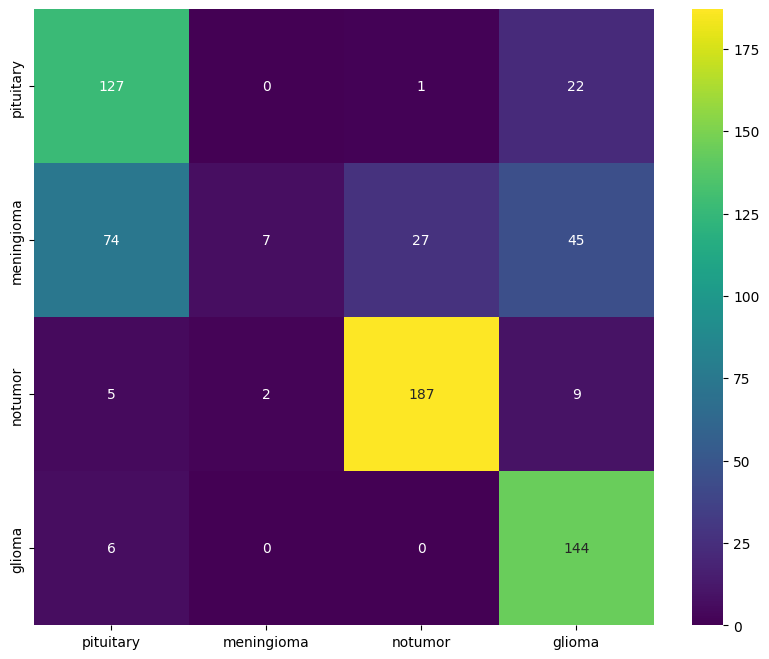

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

In [ ]:
DenseNet121.save('dense_net_121_94_91.h5')

#vgg16

In [ ]:
from tensorflow.keras import layers
vgg16_model = Sequential()
pretrained_model = tf.keras.applications.VGG16(include_top=False,
                                                  input_shape=(299, 299, 3),
                                                  pooling='max',
                                                  weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False
vgg16_model.add(pretrained_model)
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dense(4, activation='softmax'))

In [ ]:
# Compile and train the model
from tensorflow.keras.optimizers import Adam
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = vgg16_model.fit(tr_gen, validation_data=valid_gen, epochs=10)

Epoch 1/10
179/179 [==============================] - 91s 438ms/step - loss: 0.6637 - accuracy: 0.7521 - val_loss: 0.5011 - val_accuracy: 0.8107
Epoch 2/10
179/179 [==============================] - 55s 306ms/step - loss: 0.3806 - accuracy: 0.8624 - val_loss: 0.4525 - val_accuracy: 0.8382
Epoch 3/10
179/179 [==============================] - 59s 328ms/step - loss: 0.3426 - accuracy: 0.8741 - val_loss: 0.3942 - val_accuracy: 0.8534
Epoch 4/10
179/179 [==============================] - 55s 309ms/step - loss: 0.2781 - accuracy: 0.9013 - val_loss: 0.3283 - val_accuracy: 0.8733
Epoch 5/10
179/179 [==============================] - 58s 322ms/step - loss: 0.2678 - accuracy: 0.9035 - val_loss: 0.3378 - val_accuracy: 0.8672
Epoch 6/10
179/179 [==============================] - 54s 303ms/step - loss: 0.2377 - accuracy: 0.9139 - val_loss: 0.2722 - val_accuracy: 0.8977
Epoch 7/10
179/179 [==============================] - 55s 305ms/step - loss: 0.2336 - accuracy: 0.9153 - val_loss: 0.3129 - val_ac

##Evaluation

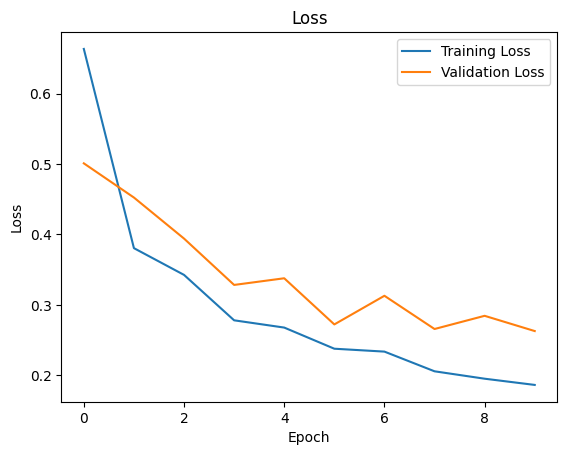

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

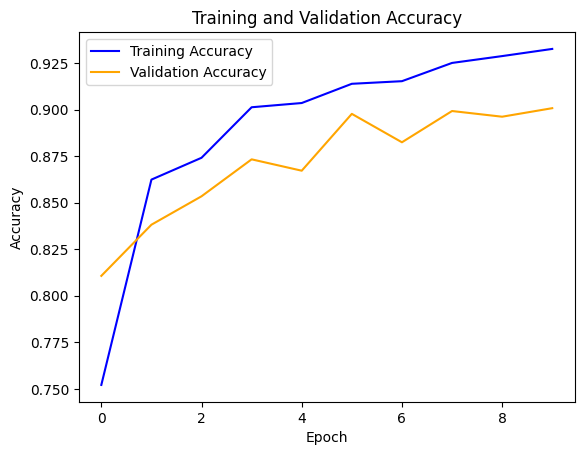

In [ ]:
import matplotlib.pyplot as plt

# Plot both training accuracy and validation accuracy on the same plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
score = vgg16_model.evaluate(ts_gen, verbose = 1)

41/41 [==============================] - 5s 127ms/step - loss: 0.2896 - accuracy: 0.8857


In [ ]:
y_test = ts_gen.classes
y_pred = vgg16_model.predict(ts_gen, verbose = 1)
y_pred = np.argmax(y_pred,axis=1)

41/41 [==============================] - 5s 126ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
train_dir='/content/Training'
labels = os.listdir(train_dir)
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

     notumor       0.95      0.73      0.82       150
   pituitary       0.77      0.88      0.82       153
  meningioma       0.99      0.96      0.97       203
      glioma       0.84      0.96      0.90       150

    accuracy                           0.89       656
   macro avg       0.89      0.88      0.88       656
weighted avg       0.90      0.89      0.89       656



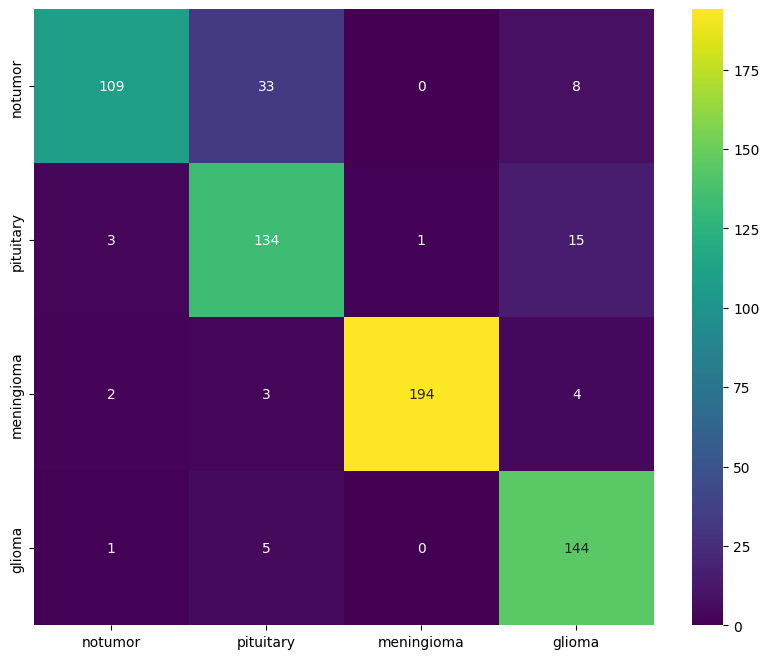

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

In [1]:
#import drive
from google.colab import drive
drive.mount('/content/drive')
print ('modules loaded')

Mounted at /content/drive
modules loaded


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.0 MB/s e

In [3]:
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf

# Load your pre-trained model for brain tumor classification
model_path = '/content/drive/MyDrive/brain_tumor/xception.h5'
brain_model = load_model(model_path)

# Define the class names for the 4 classes
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_tumor(image):
    # Resize the image to the input shape required by the model
    image = Image.fromarray(image).resize((299, 299))
    # Convert the image to a numpy array and normalize it
    image_array = np.array(image) / 255.0
    # Ensure the image has 3 channels (RGB), if not convert it
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,)*3, axis=-1)
    # Reshape the image to match the model's input shape
    image_array = image_array.reshape(-1, 299, 299, 3)
    # Predict the class using the model
    predictions = brain_model.predict(image_array)
    # Get the index of the highest prediction
    predicted_class_index = np.argmax(predictions)
    # Get the class name
    predicted_class = class_names[predicted_class_index]
    return f"Predicted Tumor Class: {predicted_class}"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    title="Brain Tumor MRI Classification",
    description="Upload an MRI image to predict the brain tumor class."
)

# Launch the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8cecc4eaf5e62f5d4d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
